In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns
import numpy as np
from joblib import dump, load

In [3]:
data_folder = "../data"
model_folder = "../models"
train_file = "train_data.csv"
test_file = "test_data.csv"
train_data = pd.read_csv(os.path.join(data_folder, train_file))
test_data = pd.read_csv(os.path.join(data_folder, test_file))
np.random.seed(2308723)
random_state = 84738

In [4]:
X_train = train_data.values[:, :-1]
y_train = train_data.values[:, -1]
X_test = test_data.values[:, :-1]
y_test = test_data.values[:, -1]

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(X_train.shape)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

(14318, 8)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
models = {}
for model_file in os.listdir(model_folder):
    model_filepath = os.path.join(model_folder, model_file)
    model_name = model_file.split(".")[0]
    model = load(model_filepath)
    models[model_name] = model

In [21]:
from sklearn.metrics import f1_score, accuracy_score, auc, confusion_matrix, precision_score, recall_score

xgb_clf = models["xgb"]
test_preds = xgb_clf.predict(X_test_scaled)

In [13]:
f1_s = f1_score(y_test, test_preds)
acc_s = accuracy_score(y_test, test_preds)
# auc_s = auc(y_test, test_preds)

In [15]:
(f1_s, acc_s)

(0.8941548183254344, 0.9812849162011174)

In [22]:
(precision_score(y_test, test_preds), recall_score(y_test, test_preds))

(0.9278688524590164, 0.8628048780487805)

In [35]:
def results(predictions, targets):
    def compare(x, y):
        if x == 1 and y == 1:
            return "true positive"
        elif x == 0 and y == 0:
            return "true negative"
        elif x == 1 and y == 0:
            return "false positive"
        else: 
            return "false negative"
    func = np.vectorize(compare)
    return func(predictions, targets)

def plot_results_2d(predictions, support_vectors=None):
    results_df = pd.DataFrame()
    results_df["comp_1"] = X_test_pca[:, 0]
    results_df["comp_2"] = X_test_pca[:, 1]
    results_df["result"] = results(predictions, y_test)

    colors = ["bright blue", "grass green", "orange", "purple"]
    my_palette = list(map(lambda x: sns.xkcd_rgb[x], colors))
    sizes = [30, 30, 300, 300]
    
    n_unique_results = results_df["result"].nunique()
    if n_unique_results  < len(my_palette):
        my_palette = my_palette[:n_unique_results]
    if n_unique_results < len(sizes):
        sizes = sizes[:n_unique_results]
    
    if support_vectors is not None:
        my_palette.append(sns.xkcd_rgb["dark grey"])
        sizes.append(300)
        
        sv_df = pd.DataFrame()
        sv_df["comp_1"] = support_vectors[:, 0]
        sv_df["comp_2"] = support_vectors[:, 1]
        sv_df["result"] = "support vector"
        results_df = pd.concat([results_df, sv_df])
        
    print(results_df["result"].value_counts())
    
    sns.set(rc={'figure.figsize':(18, 12)})
    sns.scatterplot(x="comp_1", y="comp_2", hue="result", size="result",
                    sizes=sizes, palette=my_palette, data=results_df)
    plt.xlim(-200, 400)
    plt.title("XGBoost model test results")

true negative     3230
true positive      283
false negative      45
false positive      22
Name: result, dtype: int64


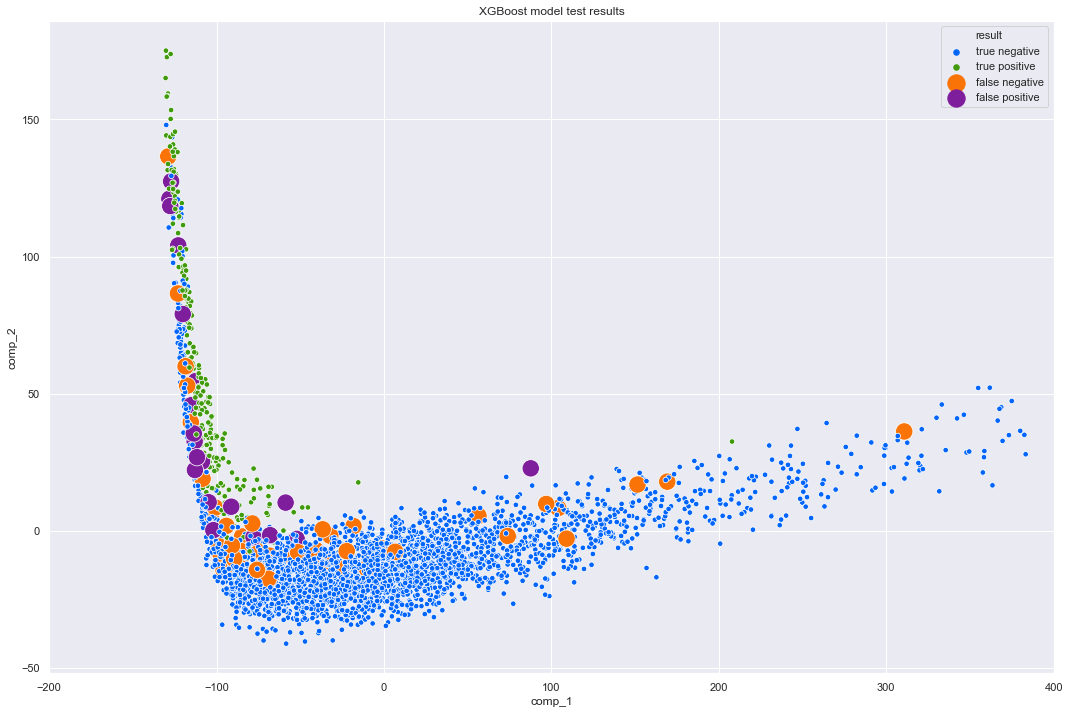

In [36]:
plot_results_2d(test_preds)

# Test Scores of all the models

In [ ]:
for name, model in models.items():
    if "rf" in name:
        preds = model.predict(X_test)
    else:
        preds = model.predict(X_test_scaled)
    f1_s = f1_score(y_train, preds)
    acc_s 